<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/Ising-VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import models & layers from TF/keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Helper libraries
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0


In [2]:
# download del dataset:
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat

#leggiamo le configurazioni ising dal file usando numpy (10k esempi oguno da 28x28 spin)
data = np.loadtxt('ising2_conf.dat')

--2020-05-31 12:37:25--  http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.150, 141.108.26.1
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.150|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19060775 (18M)
Saving to: ‘ising2_conf.dat’

ising2_conf.dat     100%[===================>]  18.18M  4.94MB/s    in 3.7s    

2020-05-31 12:37:30 (4.94 MB/s) - ‘ising2_conf.dat’ saved [19060775/19060775]



In [3]:
#riformattiamo i vettori in modo che abbiano la struttura di matrici di 28x28 spin
# (le configurazioni sono scritte nel file come 10000*28 righe ognuna di 28 elementi)
data = data.reshape(-1,28,28,1).astype('float32')
data = (data+1)/2
np.random.shuffle(data)
'''
n, m = 10, 10
fig, axs = plt.subplots(n, m, figsize=(20, 20))
for i in range(n):
  for j in range(m):
    r = np.random.randint(0, data.shape[0]-1)
    axs[i][j].imshow(data[r].reshape(28, 28))
'''

'\nn, m = 10, 10\nfig, axs = plt.subplots(n, m, figsize=(20, 20))\nfor i in range(n):\n  for j in range(m):\n    r = np.random.randint(0, data.shape[0]-1)\n    axs[i][j].imshow(data[r].reshape(28, 28))\n'

In [0]:
#Costruzione sampling layer (funzione che eredita dalla classe Layer)
#questo è il cosidetto Reparameterization Trick
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 64)     25664       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

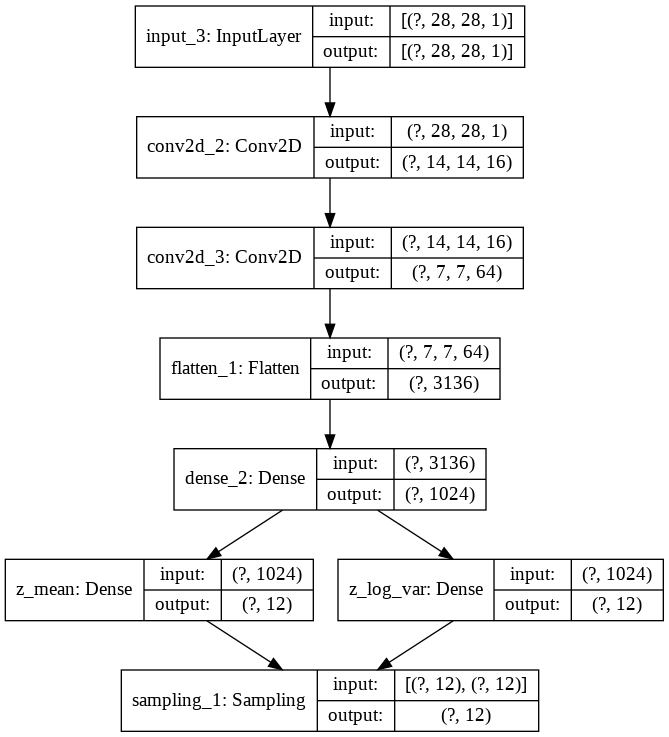

In [13]:
# Modello per l'ENCODER: immagine -> spazio latente

latent_dim = 12 #numero di dimensioni dello spazio latente

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 5, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)

# i valori dei parametri mu e sigma (log_sigma) sono scritti in layers densi senza attivazione
# notare come l'output x è passato in parallelo ai due layer densi

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling Layer: ritorna un vettore dello spazio latente z ottenuto campionando il prior 
# dello spazio latente 
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

encoder.summary()
keras.utils.plot_model(encoder, show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1568)              20384     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         257       
Total params: 76,065
Trainable params: 76,065
Non-trainable params: 0
_______________________________________________________

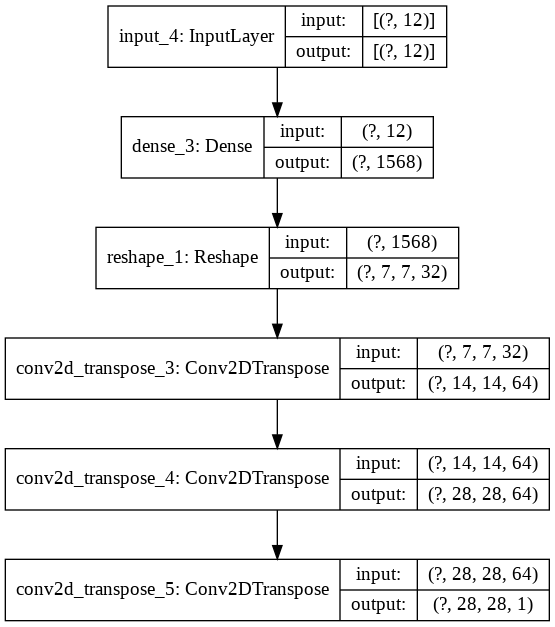

In [14]:
# Modello per il DECODER: spazio latente -> immagine

latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(7*7*32, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 32))(x)

# usiamo Conv2DTranspose (upsampling convolutions) per passare da tensori 7,7 alle dimensioni 
# volute dell'immagine MNIST 28,28
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 2, activation="sigmoid", padding="same")(x)

# NOTA: ultima attivazione sigmoide (valore dei pixel normalizzati in [0,1])

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()
keras.utils.plot_model(decoder, show_shapes=True)

In [0]:
# beta-VAE: è una VAE in cui loss = reco_loss + beta * KL-divergence
# per beta=1 riotteniamo la VAE tradizionale, per beta>1 abbiamo un vincolo più forte sul collo di bottiglia 
# dello spazio latente e quindi incoraggiando rappresentazioni più efficienti 
# dello spazio latente (e indirettamente il disentangling tra le variabili latenti). 
#
# Beta funziona da iperparametro in cui si cerca di ottenere un compremesso tra disentangling e capacità di 
# ricostuire e generare buone immagini

# NOTA IMPORTANTE: ricordarsi di ri-inizalizare encoder e decoder sopra per resttare i pesi della rete

class betaVAE(keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(betaVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def train_step(self, data):
        if isinstance(data, tuple): #controlla che data sia una python tuple come atteso per i tensori numpy
            data = data[0]
        with tf.GradientTape() as tape: #autograd 
            z_mean, z_log_var, z = encoder(data) #applica l'encoder su data e ottiene z_mean, z_log_var, z
            reconstruction = decoder(z) #applica il decoder su z e ottiene l'ouput 
            reconstruction_loss = tf.reduce_mean( #calcolo della reconstruction loss (binary cross-entropy tra input (data) e ouput (reconstruction))
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28 #applica la corretta definizione di reco_loss = d^2 \sum(...)
            
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var) #KL-divergence for multinormal distribution
            kl_loss = tf.reduce_mean(kl_loss) #calcola la media sommando sulle dimensioni latenti 
            kl_loss *= -0.5  # KL_loss = -1/2 \sum (sigma + mu^2 + 1 - log(sigma)) 

            total_loss = reconstruction_loss + self.beta*kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights) #calcola i gradienti e aggiorna i pesi
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": self.beta*kl_loss,
        }

In [15]:
beta=1
betavae = betaVAE(encoder, decoder, beta)
betavae.compile(optimizer=keras.optimizers.Adam())
betavae.fit(data, epochs=100, batch_size=512)

Epoch 1/100
20/20 [==============================] - 1s 69ms/step - loss: 484.2055 - reconstruction_loss: 476.6024 - kl_loss: 7.6031
Epoch 2/100
20/20 [==============================] - 1s 69ms/step - loss: 404.8226 - reconstruction_loss: 401.8235 - kl_loss: 2.9991
Epoch 3/100
20/20 [==============================] - 1s 69ms/step - loss: 396.9329 - reconstruction_loss: 395.1633 - kl_loss: 1.7696
Epoch 4/100
20/20 [==============================] - 1s 68ms/step - loss: 390.6829 - reconstruction_loss: 388.8601 - kl_loss: 1.8228
Epoch 5/100
20/20 [==============================] - 1s 69ms/step - loss: 376.8818 - reconstruction_loss: 374.9061 - kl_loss: 1.9757
Epoch 6/100
20/20 [==============================] - 1s 69ms/step - loss: 363.4430 - reconstruction_loss: 361.1403 - kl_loss: 2.3028
Epoch 7/100
20/20 [==============================] - 1s 69ms/step - loss: 350.3877 - reconstruction_loss: 347.7612 - kl_loss: 2.6264
Epoch 8/100
20/20 [==============================] - 1s 69ms/step - l

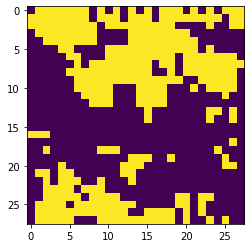

(10000, 28, 28, 1, 1)


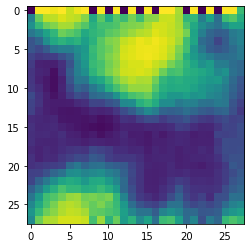

In [17]:
img = np.expand_dims(data, -1)
plt.imshow(data[4].reshape(28, 28))
plt.show()
plt.close()
print(img.shape)
z_mean, z_log_var, z = encoder.predict(img[:10])
plt.imshow(decoder.predict(z)[4].reshape(28, 28))